## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Author </h1>

Билинский Норгей, гр. 932328

### Задание 3. Обработка естественного языка
Анализ текстовых данных средствами BERT и стека LSTM

Цель работы – получить навыки обучения и использования архитектур BERT, стека LSTM и двунаправленной LSTM для задач классификации текстовых данных.

Задачи – Обучить нейросетевые модели BERT, стека LSTM, двунаправленную LSTM, предсказывающие авторство текстов по фрагменту текстов.

Выбрать 4-x поэтов из списка: Цветаева М.И., Некрасов Н.А., Лермонтов М.Ю., Тютчев Ф.И., Фет А.А., Бунин И.А., Есенин С.А., Маяковский В.В., Бродский И.А., Ахматова А.А., Блок А.А., Заболоцкий Н.А. (Можно взять любых других писателей). Для каждого выбранного поэта взять не менее 50 фрагментов из произведений, каждый фрагмент содержит не менее 100 символов.

Получить токенизатор и обученную модель BERT c HuggingFace (выбирайте подходящий для русского языка).

Выполнить загрузку и предварительную обработку данных из текстов. Разделить каждую выборку на обучающую, тестовую и валидационную.

Добавить к архитектуре BERT полносвязный (или два полносвязных) слой(я) и обучить полученную модель в следующих вариантах:

1) Заморозить веса в BERT и настроить добавленный(е) полносвязный(ые) слой(и). (Это – модель 1а)

2) Выполнить Fine-tuning полученной архитектуры. (Это – модель 1b)

Обучить вторую модель - стек LSTM (две последовательные ячейки LSTM, добавить Dropout) для классификации текстовых данных.

Обучить третью модель – двунаправленную ячейку LSTM для классификации текстовых данных.

Привести кривые изменения функции потерь (Loss) и верности (Accuracy) во время обучения на обучающем и валидационном наборах для всех .

Привести результаты обучения моделей и сделать выводы.

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Importing libraries </h1>


In [ ]:
!pip install ipywidgets
!pip install opendatasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00


In [ ]:
import re
from pathlib import Path
from typing import Optional, Tuple

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from tqdm import tqdm


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Checking the GPU environment </h1>

In [ ]:
!nvidia-smi

Sat Jan 25 11:51:53 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Data download and EDA </h1>

In [ ]:
dataset_path = Path('19-000-russian-poems', 'poems.csv')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/grafstor/19-000-russian-poems')

data = pd.read_csv(dataset_path)

def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
          return ''
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\u2003', '')
    text = text.replace('1', '').replace('i', '')
    text = text.replace('ѣ', 'е')
    text = text.lower()
    return text
data['text'] = data['text'].apply(clean_text)
data = data[data['text'].str.strip() != '']
data = data.dropna(subset=['text'])

data


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: norgey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/grafstor/19-000-russian-poems


100%|██████████| 13.3M/13.3M [00:00<00:00, 85.8MB/s]

,writer,poem,text
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,на серебряные шпоры я в раздумии гляжу за тебя...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,пилигрим аллах ли там среди пустыни застывших ...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)",о не скрывай ты плакала об нем и я его люблю о...
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)",ты знал ли дикий край под знойными лучами где ...
5,Лермонтов Михаил Юрьевич,К кн. Л. Г-ой,когда ты холодно внимаешь рассказам горести чу...
...,...,...,...
19311,Владислав Фелицианович Ходасевич,Прогулка,хорошо что в этом мире есть магические ночи ме...
19312,Владислав Фелицианович Ходасевич,Пробочка,пробочка над крепким иодом как ты скоро перетл...
19313,Владислав Фелицианович Ходасевич,"Друзья, друзья! Быть может, скоро…",друзья друзья быть может скоро и не во сне а н...
19314,Владислав Фелицианович Ходасевич,"Увы, дитя! Душе неутоленной…",увы дитя душе неутоленной не снишься ль ты нев...


In [ ]:
data['writer'].unique()

array(['Лермонтов Михаил Юрьевич', 'Максимилиан Александрович Волошин',
       'Пушкин Александр Сергеевич', 'Николай Михайлович Карамзин',
       'Саша Чёрный', 'Анненский Иннокентий Федорович',
       'Владимир Сергеевич Соловьев', 'Маяковский Владимир Владимирович',
       'Дмитрий Владимирович Веневитинов',
       'Аполлон Александрович Григорьев', 'Фёдор Кузьмич Сологуб',
       'Брюсов Валерий Яковлевич', 'Алексей Николаевич Апухтин',
       'Аделаида Казимировна Герцык', 'Алексей Васильевич Кольцов',
       'Александр Николаевич Радищев', 'Некрасов Николай Алексеевич',
       'Андрей Белый', 'Александр Петрович Сумароков',
       'Агнивцев Николай Яковлевич', 'Кондратий Фёдорович Рылеев',
       'Фет Афанасий Афанасьевич', 'Михаил Васильевич Ломоносов',
       'Пётр Андреевич Вяземский', 'Ахматова Анна Андреевна',
       'Тютчев Федор Иванович', 'Галина Галина',
       'Павел Александрович Катенин', 'Цветаева Марина Ивановна',
       'Блок Александр Александрович', 'Иван Саввич 

In [ ]:
poem_counts = data.groupby('writer')['poem'].count().reset_index()
poem_counts.columns = ['writer', 'poem_count']
poem_counts_sorted = poem_counts.sort_values(by='poem_count', ascending=False)
poem_counts_sorted = poem_counts_sorted.reset_index(drop=True)
poem_counts_sorted[:10]


,writer,poem_count
0,Брюсов Валерий Яковлевич,1607
1,Игорь Северянин,1597
2,Александр Петрович Сумароков,1520
3,Блок Александр Александрович,1282
4,Маяковский Владимир Владимирович,1279
5,Фёдор Кузьмич Сологуб,1163
6,Бальмонт Константин Дмитриевич,990
7,Фет Афанасий Афанасьевич,888
8,Пушкин Александр Сергеевич,750
9,Цветаева Марина Ивановна,535


In [ ]:
authors_to_keep = [
    'Александр Петрович Сумароков',
    'Блок Александр Александрович',
    'Маяковский Владимир Владимирович',
    'Бальмонт Константин Дмитриевич'
]
df = data.loc[data['writer'].isin(authors_to_keep)]
df


,writer,poem,text
2030,Маяковский Владимир Владимирович,Воровский,сегодня пролетариат гром голосов раскуй забудь...
2031,Маяковский Владимир Владимирович,Раньше офицера только рубить учили… (РОСТА №632),раньше офицера только рубить учили только стр...
2032,Маяковский Владимир Владимирович,"Рабочим Курска, добывшим первую руду,временный...",было социализм восторженное слово с флагом с п...
2033,Маяковский Владимир Владимирович,Вот по 11-е ноября отчет (Главполитпросвет №407),денег по москве поступило всего 0 84 878 58 р...
2034,Маяковский Владимир Владимирович,Халтурщик,пролетарий туп жестоко дуб дремучий в блузной ...
...,...,...,...
15046,Бальмонт Константин Дмитриевич,Кому я молюсь,кому я молюсь холодному ветру кому я молюсь ра...
15047,Бальмонт Константин Дмитриевич,С морского дна,на темном влажном дне морском где царство бле...
15048,Бальмонт Константин Дмитриевич,Черные вороны,черные вороны воры играли над нами каркали ден...
15049,Бальмонт Константин Дмитриевич,Безглагольность,есть в русской природе усталая нежность безмол...


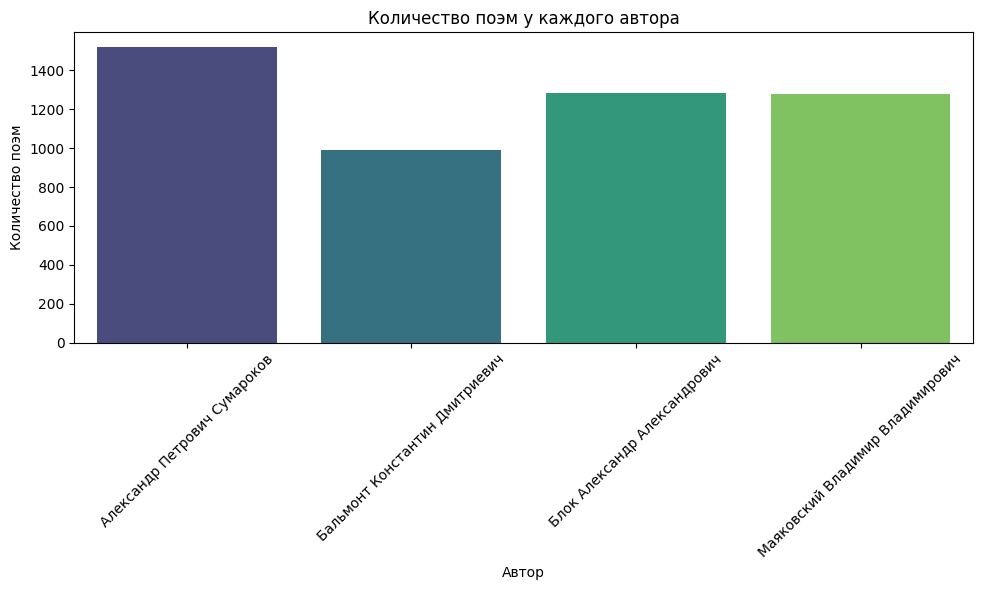

In [ ]:
poem_counts = df.groupby('writer')['poem'].count().reset_index()
poem_counts.columns = ['writer', 'poem_count']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='writer',
    y='poem_count',
    hue='writer',
    data=poem_counts,
    palette='viridis',
    legend=False
    )
plt.title('Количество поэм у каждого автора')
plt.xlabel('Автор')
plt.ylabel('Количество поэм')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-8-0d0987b33611>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('writer', group_keys=False).apply(


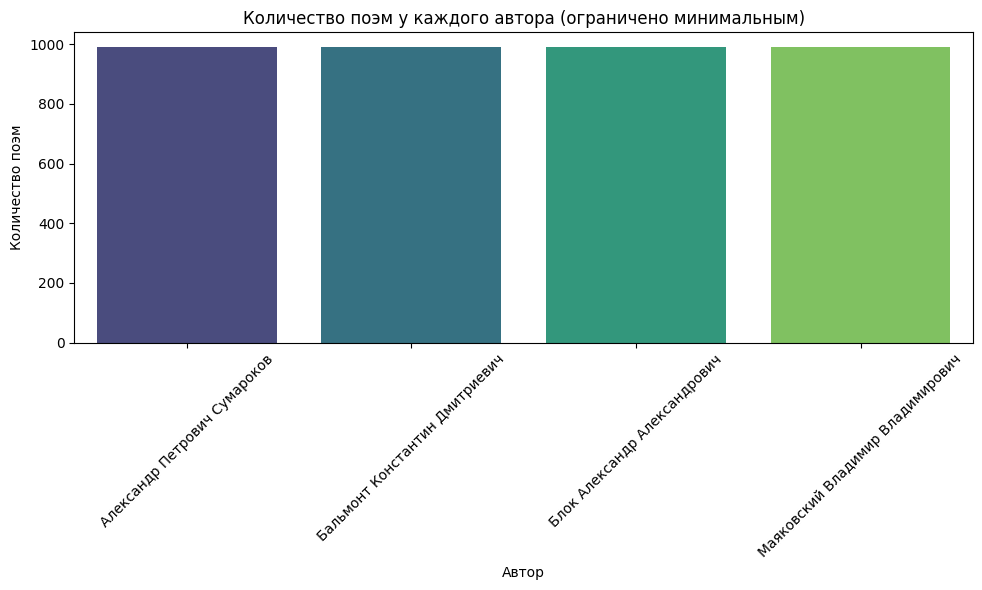

In [ ]:
min_poem_count = poem_counts['poem_count'].min()

def limit_poems(group, limit):
    return group.head(limit)

df = df.groupby('writer', group_keys=False).apply(
    lambda x: limit_poems(x, min_poem_count)
    )

poem_counts_updated = df.groupby('writer')['poem'].count().reset_index()
poem_counts_updated.columns = ['writer', 'poem_count']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='writer',
    y='poem_count',
    hue='writer',
    data=poem_counts_updated,
    palette='viridis',
    legend=False
)
plt.title('Количество поэм у каждого автора (ограничено минимальным)')
plt.xlabel('Автор')
plt.ylabel('Количество поэм')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_shuffled = df.groupby('writer', group_keys=False).apply(
    lambda x: x.sample(frac=1, random_state=42)
    )
df_shuffled = df_shuffled.drop(columns=['poem'])

author_to_code = {author: idx for idx, author in enumerate(authors_to_keep)}
df_shuffled['writer'] = df_shuffled['writer'].map(author_to_code)

def split_group(group):
    n = len(group)
    train_size = int(n * 0.8)
    val_size = int(n * 0.1)
    test_size = n - train_size - val_size

    train = group.iloc[:train_size]
    val = group.iloc[train_size:train_size + val_size]
    test = group.iloc[train_size + val_size:]

    return train, val, test

train_parts, val_parts, test_parts = [], [], []

for writer, group in df_shuffled.groupby('writer'):
    train, val, test = split_group(group)
    train_parts.append(train)
    val_parts.append(val)
    test_parts.append(test)

train_df = pd.concat(train_parts).reset_index(drop=True)
val_df = pd.concat(val_parts).reset_index(drop=True)
test_df = pd.concat(test_parts).reset_index(drop=True)

print("Обучающий набор:")
print(train_df.shape)
print("\nВалидационный набор:")
print(val_df.shape)
print("\nТестовый набор:")
print(test_df.shape)

train_df


Обучающий набор:
(3168, 2)

Валидационный набор:
(396, 2)

Тестовый набор:
(396, 2)


<ipython-input-9-6fd2841c569c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df.groupby('writer', group_keys=False).apply(


,writer,text
0,0,поверь мой светъ люблю тебя лишь только то ска...
1,0,по мрачной нощи приятно воспевалъ на древе сол...
2,0,трепещетъ понтъ въ водахъ огонь и флотъ горитъ...
3,0,хромова волкъ коня увиделъ вотъ мой светъ себе...
4,0,на пастве двумъ сердцамъ любовь во сне не зрел...
...,...,...
3163,3,чайка серая чайка с печальными криками носится...
3164,3,зачем мы торопимся к яркости чувства в которой...
3165,3,в чисто поле я пойду речь с ветрами поведу вет...
3166,3,когда я к другому в упор подхожу я знаю нам об...


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;">  Additional training Bert </h1>

In [ ]:
# Класс для создания датасета, совместимого с PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        """
        Инициализация датасета.

        :param dataframe: DataFrame, содержащий тексты и метки.
        :param tokenizer: Токенизатор для преобразования текста в токены.
        :param max_len: Максимальная длина последовательности токенов.
        """
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Возвращает элемент датасета по индексу.

        :param index: Индекс элемента.
        :return: Словарь, содержащий input_ids, attention_mask и метку.
        """
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['writer']

        # Токенизация текста
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,  # Ограничение длины последовательности
            padding='max_length',     # Дополнение до максимальной длины
            truncation=True,          # Обрезка текста, если он превышает max_len
            return_tensors="pt"       # Возврат тензоров PyTorch
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Убираем лишнюю размерность
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Убираем лишнюю размерность
            'label': torch.tensor(label, dtype=torch.long)  # Преобразуем метку в тензор
        }


# Класс для создания модели на основе BERT
class CustomBERTModel(nn.Module):
    def __init__(self, bert, num_classes, freeze_bert):
        """
        Инициализация модели.

        :param bert: Предобученная модель BERT.
        :param num_classes: Количество классов для классификации.
        :param freeze_bert: Флаг, указывающий, нужно ли замораживать параметры BERT.
        """
        super(CustomBERTModel, self).__init__()
        self.bert = bert

        # Замораживаем параметры BERT, если freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Добавляем полносвязные слои для классификации
        self.fc = nn.Sequential(
            nn.Linear(bert.config.hidden_size, 512),  # Линейный слой (768 -> 512)
            nn.ReLU(),                                # Функция активации
            nn.Dropout(0.3),                          # Dropout для регуляризации

            nn.Linear(512, 256),                      # Линейный слой (512 -> 256)
            nn.ReLU(),                                # Функция активации
            nn.Dropout(0.3),                          # Dropout для регуляризации

            nn.Linear(256, num_classes)               # Выходной слой (256 -> num_classes)
        )

    def forward(self, input_ids, attention_mask):
        """
        Прямой проход модели.

        :param input_ids: Тензор с индексами токенов.
        :param attention_mask: Тензор с маской внимания.
        :return: Выход модели (логиты для классификации).
        """
        # Получаем выходы BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Используем pooler_output (вектор [CLS]) как общее представление текста
        pooled_output = outputs.pooler_output

        # Пропускаем pooled_output через полносвязные слои
        return self.fc(pooled_output)


class Trainer:
    """
    Класс для обучения и оценки модели.

    Атрибуты:
        model: Модель, которую нужно обучать и оценивать.
        device: Устройство (CPU или GPU), на котором выполняется обучение.
    """

    def __init__(self, model, device):
        """
        Инициализация Trainer.

        :param model: Модель для обучения и оценки.
        :param device: Устройство (например, 'cuda' или 'cpu').
        """
        self.model = model
        self.device = device

    def train_model(self, dataloader, optimizer, criterion):
        """
        Обучает модель на данных из dataloader.

        :param dataloader: DataLoader, предоставляющий обучающие данные.
        :param optimizer: Оптимизатор для обновления параметров модели.
        :param criterion: Функция потерь для вычисления ошибки.
        :return: Среднее значение потерь за эпоху.
        """
        self.model.train()  # Переводим модель в режим обучения
        total_loss = 0

        # Итерация по батчам данных
        for batch in tqdm(dataloader, desc="Training"):
            # Переносим данные на устройство
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход: вычисляем выходы модели
            outputs = self.model(input_ids, attention_mask)

            # Вычисляем потери
            loss = criterion(outputs, labels)

            # Обратный проход: вычисляем градиенты
            loss.backward()

            # Обновляем параметры модели
            optimizer.step()

            # Суммируем потери
            total_loss += loss.item()

        # Возвращаем среднее значение потерь за эпоху
        return total_loss / len(dataloader)

    def evaluate_model(self, dataloader, criterion):
        """
        Оценивает модель на данных из dataloader.

        :param dataloader: DataLoader, предоставляющий данные для оценки.
        :param criterion: Функция потерь для вычисления ошибки.
        :return: Среднее значение потерь и точность на данных.
        """
        self.model.eval()  # Переводим модель в режим оценки
        total_loss = 0
        correct = 0

        # Отключаем вычисление градиентов для ускорения и экономии памяти
        with torch.no_grad():
            # Итерация по батчам данных
            for batch in dataloader:
                # Переносим данные на устройство (GPU или CPU)
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)

                # Прямой проход: вычисляем выходы модели
                outputs = self.model(input_ids, attention_mask)

                # Вычисляем потери
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Вычисляем предсказания (индекс класса с максимальной вероятностью)
                preds = torch.argmax(outputs, dim=1)

                # Считаем количество правильных предсказаний
                correct += (preds == labels).sum().item()

        # Возвращаем среднее значение потерь и точность
        return total_loss / len(dataloader), correct / len(dataloader.dataset)


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 1a frozen weights</h1>


In [ ]:
MAX_LEN = 512
BATCH_SIZE = 64
NUM_EPOCH = 100

PRETRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
bert_model_1 = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TextDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_df, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_1a = CustomBERTModel(
    bert_model_1,
    num_classes=train_df['writer'].nunique(),
    freeze_bert=True
    ).to(device)
optimizer = optim.AdamW(model_1a.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model_1a, device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Параметры для ранней остановки
patience = 3  # Количество эпох, в течение которых потери не должны уменьшаться
min_delta = 0.005  # Минимальное значимое уменьшение потерь
best_val_loss = np.inf  # Лучшее значение потерь на валидации (np.inf положительная бесконечность)
epochs_without_improvement = 0  # Счётчик эпох без улучшения

epoch_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=NUM_EPOCH,
    description='Epochs:',
    bar_style='info',
    orientation='horizontal'
)
display(epoch_progress)

for epoch in range(NUM_EPOCH):
    epoch_progress.value = epoch

    train_loss = trainer.train_model(train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Сохраняем значение потерь на обучении

    train_accuracy = trainer.evaluate_model(train_dataloader, criterion)[1]
    train_accuracies.append(train_accuracy)  # Сохраняем точность на обучении

    val_loss, val_accuracy = trainer.evaluate_model(val_dataloader, criterion)
    val_losses.append(val_loss)  # Сохраняем значение потерь на валидации
    val_accuracies.append(val_accuracy)  # Сохраняем точность на валидации

    print(f"Epoch {epoch + 1}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}!")
        break

print('---' * 30)
test_loss, test_accuracy = trainer.evaluate_model(test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

epoch_progress.bar_style = 'success'


pytorch_model.bin:  48%|####8     | 346M/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


IntProgress(value=0, bar_style='info', description='Epochs:')

Training: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


Epoch 1, Train Loss: 1.3811, Train Accuracy: 0.4403, Val Loss: 1.3733, Val Accuracy: 0.4646


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 2, Train Loss: 1.3647, Train Accuracy: 0.4381, Val Loss: 1.3602, Val Accuracy: 0.4242


Training: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


Epoch 3, Train Loss: 1.3485, Train Accuracy: 0.4580, Val Loss: 1.3423, Val Accuracy: 0.4268


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 4, Train Loss: 1.3265, Train Accuracy: 0.4877, Val Loss: 1.3203, Val Accuracy: 0.4621


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 5, Train Loss: 1.2998, Train Accuracy: 0.5502, Val Loss: 1.2925, Val Accuracy: 0.5480


Training: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


Epoch 6, Train Loss: 1.2612, Train Accuracy: 0.5840, Val Loss: 1.2538, Val Accuracy: 0.5556


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 7, Train Loss: 1.2169, Train Accuracy: 0.6373, Val Loss: 1.2092, Val Accuracy: 0.6237


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 8, Train Loss: 1.1600, Train Accuracy: 0.6572, Val Loss: 1.1537, Val Accuracy: 0.6465


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 9, Train Loss: 1.1074, Train Accuracy: 0.6736, Val Loss: 1.0914, Val Accuracy: 0.6616


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 10, Train Loss: 1.0488, Train Accuracy: 0.7131, Val Loss: 1.0304, Val Accuracy: 0.6843


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 11, Train Loss: 0.9805, Train Accuracy: 0.7399, Val Loss: 0.9704, Val Accuracy: 0.7121


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 12, Train Loss: 0.9207, Train Accuracy: 0.7412, Val Loss: 0.9186, Val Accuracy: 0.7172


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 13, Train Loss: 0.8723, Train Accuracy: 0.7244, Val Loss: 0.8794, Val Accuracy: 0.6944


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 14, Train Loss: 0.8215, Train Accuracy: 0.7475, Val Loss: 0.8337, Val Accuracy: 0.7172


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 15, Train Loss: 0.7862, Train Accuracy: 0.7579, Val Loss: 0.7993, Val Accuracy: 0.7374


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 16, Train Loss: 0.7602, Train Accuracy: 0.7541, Val Loss: 0.7679, Val Accuracy: 0.7323


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 17, Train Loss: 0.7318, Train Accuracy: 0.7648, Val Loss: 0.7411, Val Accuracy: 0.7500


Training: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


Epoch 18, Train Loss: 0.7139, Train Accuracy: 0.7951, Val Loss: 0.7122, Val Accuracy: 0.7576


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 19, Train Loss: 0.6862, Train Accuracy: 0.7623, Val Loss: 0.7057, Val Accuracy: 0.7449


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 20, Train Loss: 0.6731, Train Accuracy: 0.7715, Val Loss: 0.6911, Val Accuracy: 0.7525


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 21, Train Loss: 0.6559, Train Accuracy: 0.7838, Val Loss: 0.6711, Val Accuracy: 0.7702


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 22, Train Loss: 0.6462, Train Accuracy: 0.7835, Val Loss: 0.6635, Val Accuracy: 0.7677


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 23, Train Loss: 0.6253, Train Accuracy: 0.7914, Val Loss: 0.6437, Val Accuracy: 0.7778


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 24, Train Loss: 0.6264, Train Accuracy: 0.7932, Val Loss: 0.6354, Val Accuracy: 0.7803


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 25, Train Loss: 0.6112, Train Accuracy: 0.8011, Val Loss: 0.6230, Val Accuracy: 0.7828


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 26, Train Loss: 0.5963, Train Accuracy: 0.8015, Val Loss: 0.6133, Val Accuracy: 0.7803


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 27, Train Loss: 0.5949, Train Accuracy: 0.8037, Val Loss: 0.6109, Val Accuracy: 0.7955


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 28, Train Loss: 0.5858, Train Accuracy: 0.8081, Val Loss: 0.5967, Val Accuracy: 0.7803


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 29, Train Loss: 0.5718, Train Accuracy: 0.8081, Val Loss: 0.5933, Val Accuracy: 0.7980


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 30, Train Loss: 0.5772, Train Accuracy: 0.8125, Val Loss: 0.5826, Val Accuracy: 0.7904


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 31, Train Loss: 0.5633, Train Accuracy: 0.8144, Val Loss: 0.5782, Val Accuracy: 0.7929


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 32, Train Loss: 0.5612, Train Accuracy: 0.8122, Val Loss: 0.5727, Val Accuracy: 0.8030


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 33, Train Loss: 0.5455, Train Accuracy: 0.8147, Val Loss: 0.5666, Val Accuracy: 0.7854


Training: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Epoch 34, Train Loss: 0.5571, Train Accuracy: 0.8213, Val Loss: 0.5592, Val Accuracy: 0.7980


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 35, Train Loss: 0.5439, Train Accuracy: 0.8147, Val Loss: 0.5584, Val Accuracy: 0.7879


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 36, Train Loss: 0.5367, Train Accuracy: 0.8182, Val Loss: 0.5525, Val Accuracy: 0.7980


Training: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


Epoch 37, Train Loss: 0.5248, Train Accuracy: 0.8210, Val Loss: 0.5423, Val Accuracy: 0.7879


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 38, Train Loss: 0.5230, Train Accuracy: 0.8207, Val Loss: 0.5362, Val Accuracy: 0.8005


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 39, Train Loss: 0.5343, Train Accuracy: 0.8210, Val Loss: 0.5351, Val Accuracy: 0.8005


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 40, Train Loss: 0.5213, Train Accuracy: 0.8229, Val Loss: 0.5296, Val Accuracy: 0.8131


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 41, Train Loss: 0.5157, Train Accuracy: 0.8217, Val Loss: 0.5296, Val Accuracy: 0.8030


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 42, Train Loss: 0.5151, Train Accuracy: 0.8232, Val Loss: 0.5218, Val Accuracy: 0.8081


Training: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


Epoch 43, Train Loss: 0.5273, Train Accuracy: 0.8280, Val Loss: 0.5149, Val Accuracy: 0.8106


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 44, Train Loss: 0.5114, Train Accuracy: 0.8305, Val Loss: 0.5067, Val Accuracy: 0.8081


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 45, Train Loss: 0.5067, Train Accuracy: 0.8286, Val Loss: 0.5019, Val Accuracy: 0.8056


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 46, Train Loss: 0.4972, Train Accuracy: 0.8292, Val Loss: 0.5008, Val Accuracy: 0.8030


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 47, Train Loss: 0.5248, Train Accuracy: 0.8346, Val Loss: 0.4955, Val Accuracy: 0.8157


Training: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


Epoch 48, Train Loss: 0.5030, Train Accuracy: 0.8336, Val Loss: 0.4920, Val Accuracy: 0.8081


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 49, Train Loss: 0.5050, Train Accuracy: 0.8336, Val Loss: 0.4964, Val Accuracy: 0.8182


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 50, Train Loss: 0.4894, Train Accuracy: 0.8362, Val Loss: 0.4842, Val Accuracy: 0.8207


Training: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Epoch 51, Train Loss: 0.4823, Train Accuracy: 0.8336, Val Loss: 0.4869, Val Accuracy: 0.8258


Training: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


Epoch 52, Train Loss: 0.4892, Train Accuracy: 0.8365, Val Loss: 0.4797, Val Accuracy: 0.8207


Training: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


Epoch 53, Train Loss: 0.4901, Train Accuracy: 0.8381, Val Loss: 0.4809, Val Accuracy: 0.8232
Early stopping at epoch 52!
------------------------------------------------------------------------------------------
Test Loss: 0.4459, Test Accuracy: 0.8258


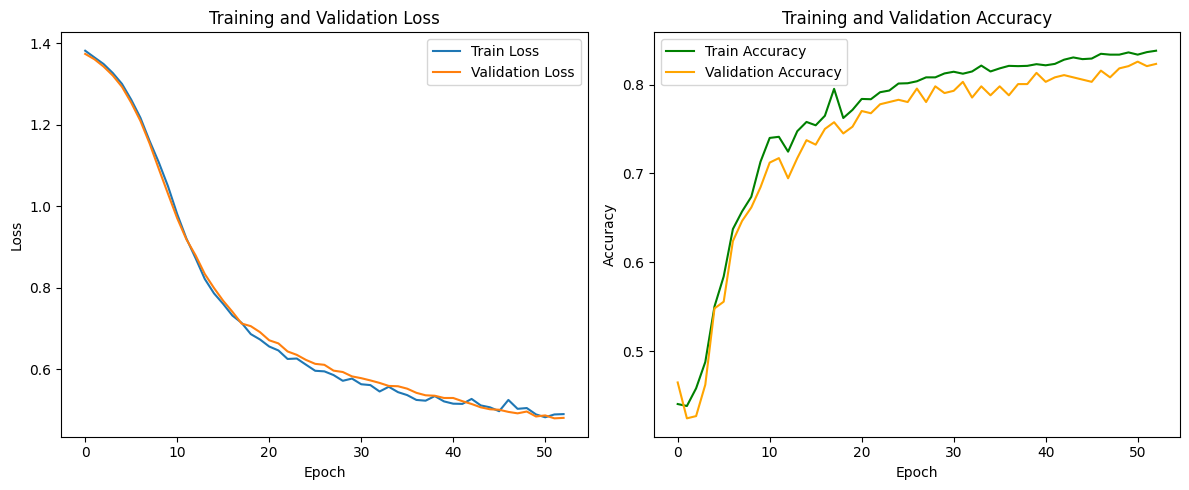

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> 1b fine-tuning</h1>


In [ ]:
MAX_LEN = 512
BATCH_SIZE = 32
NUM_EPOCH = 55

PRETRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
bert_model_2 = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TextDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_df, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_1b = CustomBERTModel(
    bert_model_2,
    num_classes=train_df['writer'].nunique(),
    freeze_bert=False
    ).to(device)
optimizer = optim.AdamW(model_1b.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model_1b, device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Параметры для ранней остановки
patience = 2  # Количество эпох, в течение которых потери не должны уменьшаться
min_delta = 0.001  # Минимальное значимое уменьшение потерь
best_val_loss = np.inf  # Лучшее значение потерь на валидации (np.inf положительная бесконечность)
epochs_without_improvement = 0  # Счётчик эпох без улучшения

epoch_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=NUM_EPOCH,
    description='Epochs:',
    bar_style='info',
    orientation='horizontal'
)
display(epoch_progress)

for epoch in range(NUM_EPOCH):
    epoch_progress.value = epoch

    train_loss = trainer.train_model(train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Сохраняем значение потерь на обучении

    train_accuracy = trainer.evaluate_model(train_dataloader, criterion)[1]
    train_accuracies.append(train_accuracy)  # Сохраняем точность на обучении

    val_loss, val_accuracy = trainer.evaluate_model(val_dataloader, criterion)
    val_losses.append(val_loss)  # Сохраняем значение потерь на валидации
    val_accuracies.append(val_accuracy)  # Сохраняем точность на валидации

    print(f"Epoch {epoch + 1}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}!")
        break

print('---' * 30)
test_loss, test_accuracy = trainer.evaluate_model(test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

epoch_progress.bar_style = 'success'


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


IntProgress(value=0, bar_style='info', description='Epochs:', max=55)

Training: 100%|██████████| 99/99 [04:47<00:00,  2.90s/it]


Epoch 1, Train Loss: 0.9589, Train Accuracy: 0.8280, Val Loss: 0.6232, Val Accuracy: 0.8333


Training: 100%|██████████| 99/99 [04:56<00:00,  2.99s/it]


Epoch 2, Train Loss: 0.5250, Train Accuracy: 0.7639, Val Loss: 0.4393, Val Accuracy: 0.7525


Training: 100%|██████████| 99/99 [04:56<00:00,  2.99s/it]


Epoch 3, Train Loss: 0.3500, Train Accuracy: 0.9438, Val Loss: 0.2832, Val Accuracy: 0.8965


Training: 100%|██████████| 99/99 [04:56<00:00,  3.00s/it]


Epoch 4, Train Loss: 0.2242, Train Accuracy: 0.9801, Val Loss: 0.2729, Val Accuracy: 0.9192


Training: 100%|██████████| 99/99 [04:56<00:00,  3.00s/it]


Epoch 5, Train Loss: 0.1257, Train Accuracy: 0.9934, Val Loss: 0.2288, Val Accuracy: 0.9242


Training: 100%|██████████| 99/99 [04:56<00:00,  3.00s/it]


Epoch 6, Train Loss: 0.0887, Train Accuracy: 0.9934, Val Loss: 0.2844, Val Accuracy: 0.9293


Training: 100%|██████████| 99/99 [04:56<00:00,  3.00s/it]


Epoch 7, Train Loss: 0.0432, Train Accuracy: 0.9918, Val Loss: 0.3341, Val Accuracy: 0.9091
Early stopping at epoch 6!
------------------------------------------------------------------------------------------
Test Loss: 0.3497, Test Accuracy: 0.9141


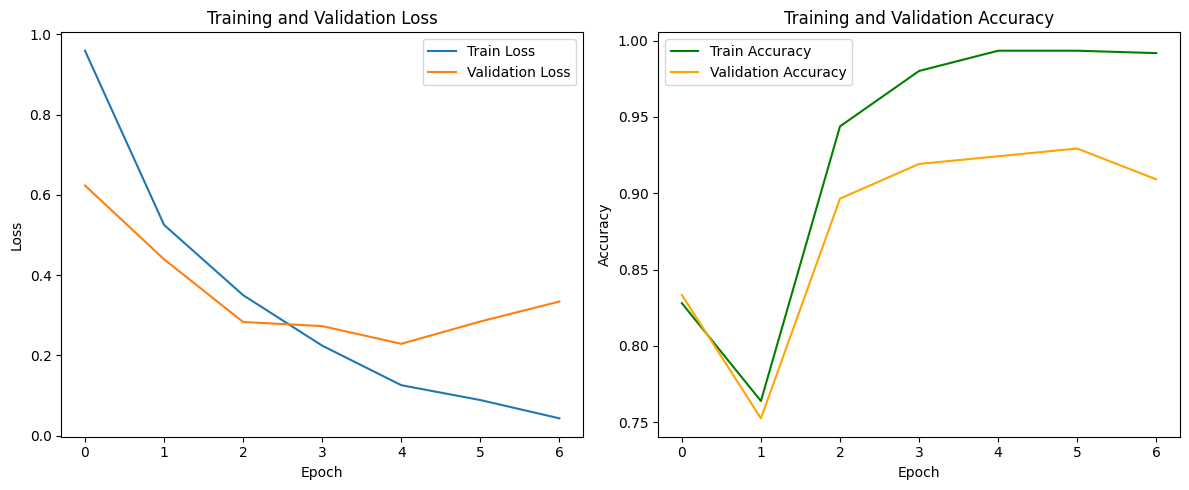

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


 ## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> LSTM </h1>


__Обычная (однонаправленная) LSTM:__

* Обрабатывает последовательность входных данных (например, слова в предложении) в одном направлении, то есть, от начала к концу.

* Состояние скрытой ячейки (hidden state) на каждом шаге зависит только от предыдущих шагов.

* Подходит, когда контекст важен только в одном направлении (например, для генерации текста слева направо).

__Двунаправленная LSTM (bidirectional=True):__

*Обрабатывает входную последовательность в двух направлениях: от начала к концу и от конца к началу.

*Состоит из двух LSTM: одной, которая обрабатывает последовательность в прямом направлении (forward LSTM) и другой, которая обрабатывает ее в обратном направлении (backward LSTM).

*На каждом шаге скрытое состояние является конкатенацией скрытых состояний forward и backward LSTM.

*Позволяет модели учитывать контекст как слева, так и справа от текущего элемента последовательности.

Подходит для задач, где контекст важен в обоих направлениях, например:

* Классификация текста: нужно понять смысл слова, учитывая слова до и после него.

* NER (Named Entity Recognition): нужно определить, является ли слово именем, местом и т.д.

* Машинный перевод: нужно учитывать контекст всего предложения.

In [ ]:
# Класс для создания датасета, совместимого с PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        """
        Инициализация датасета.

        :param dataframe: DataFrame, содержащий тексты и метки.
        :param tokenizer: Токенизатор для преобразования текста в токены.
        :param max_len: Максимальная длина последовательности токенов.
        """
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Возвращает элемент датасета по индексу.

        :param index: Индекс элемента.
        :return: Словарь, содержащий input_ids, attention_mask и метку.
        """
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['writer']

        # Токенизация текста
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,  # Ограничение длины последовательности
            padding='max_length',     # Дополнение до максимальной длины
            truncation=True,          # Обрезка текста, если он превышает max_len
            return_tensors="pt"       # Возврат тензоров PyTorch
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Убираем лишнюю размерность
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Убираем лишнюю размерность
            'label': torch.tensor(label, dtype=torch.long)  # Преобразуем метку в тензор
        }


class Trainer:
    """
    Класс для обучения и оценки модели.

    Атрибуты:
        model: Модель, которую нужно обучать и оценивать.
        device: Устройство (CPU или GPU), на котором выполняется обучение.
    """

    def __init__(self, model, device):
        """
        Инициализация Trainer.

        :param model: Модель для обучения и оценки.
        :param device: Устройство (например, 'cuda' или 'cpu').
        """
        self.model = model
        self.device = device

    def train_model(self, dataloader, optimizer, criterion):
        """
        Обучает модель на данных из dataloader.

        :param dataloader: DataLoader, предоставляющий обучающие данные.
        :param optimizer: Оптимизатор для обновления параметров модели.
        :param criterion: Функция потерь для вычисления ошибки.
        :return: Среднее значение потерь за эпоху.
        """
        self.model.train()  # Переводим модель в режим обучения
        total_loss = 0

        # Итерация по батчам данных
        for batch in tqdm(dataloader, desc="Training"):
            # Переносим данные на устройство
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход: вычисляем выходы модели
            outputs = self.model(input_ids, attention_mask)

            # Вычисляем потери
            loss = criterion(outputs, labels)

            # Обратный проход: вычисляем градиенты
            loss.backward()

            # Обновляем параметры модели
            optimizer.step()

            # Суммируем потери
            total_loss += loss.item()

        # Возвращаем среднее значение потерь за эпоху
        return total_loss / len(dataloader)

    def evaluate_model(self, dataloader, criterion):
        """
        Оценивает модель на данных из dataloader.

        :param dataloader: DataLoader, предоставляющий данные для оценки.
        :param criterion: Функция потерь для вычисления ошибки.
        :return: Среднее значение потерь и точность на данных.
        """
        self.model.eval()  # Переводим модель в режим оценки
        total_loss = 0
        correct = 0

        # Отключаем вычисление градиентов для ускорения и экономии памяти
        with torch.no_grad():
            # Итерация по батчам данных
            for batch in dataloader:
                # Переносим данные на устройство (GPU или CPU)
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)

                # Прямой проход: вычисляем выходы модели
                outputs = self.model(input_ids, attention_mask)

                # Вычисляем потери
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Вычисляем предсказания (индекс класса с максимальной вероятностью)
                preds = torch.argmax(outputs, dim=1)

                # Считаем количество правильных предсказаний
                correct += (preds == labels).sum().item()

        # Возвращаем среднее значение потерь и точность
        return total_loss / len(dataloader), correct / len(dataloader.dataset)



### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> LSTM stack</h1>


In [ ]:
class LSTMModel(nn.Module):
    """
    Модель LSTM с механизмом внимания.

    Эта модель использует LSTM для обработки последовательностей текста,
    применяет механизм внимания для взвешивания важности различных позиций в последовательности,
    и затем проецирует результат на выходной слой для классификации.
    """
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int, n_layers: int, dropout: float):
        """
        Инициализирует слои модели.

        Параметры:
            vocab_size (int): Размер словаря (количество уникальных слов).
            embedding_dim (int): Размерность векторного представления слова.
            hidden_dim (int): Размерность скрытого состояния LSTM.
            output_dim (int): Размерность выходного слоя (количество классов).
            n_layers (int): Количество слоев LSTM.
            dropout (float): Вероятность dropout.
        """
        super(LSTMModel, self).__init__()

        # Слой эмбеддингов для преобразования индексов слов в векторы
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Слой батч-нормализации
        self.bn = nn.BatchNorm1d(embedding_dim)
        # Слой LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
            )
        # Слой dropout
        self.dropout = nn.Dropout(dropout)
        # Полносвязный слой для классификации
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Полносвязный слой для механизма внимания
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Инициализация весов LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, text: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Прямой проход модели.

        Параметры:
            text (torch.Tensor): Входные данные (последовательность индексов слов).
                                Форма: (batch_size, seq_len)
            attention_mask (torch.Tensor, optional): Маска внимания. По умолчанию None.
                                                     Форма: (batch_size, seq_len)
        Возвращает:
            torch.Tensor: Выход модели (логиты для классификации).
                          Форма: (batch_size, output_dim)
        """
        # Преобразуем индексы слов в эмбеддинги
        embedded = self.embedding(text)

        # Применяем маску, если она предоставлена
        if attention_mask is not None:
            embedded = embedded * attention_mask.unsqueeze(-1)

        # Применяем батч-нормализацию к эмбеддингам
        embedded = self.bn(embedded.transpose(1, 2)).transpose(1, 2)

        # Пропускаем эмбеддинги через LSTM
        lstm_out, _ = self.lstm(embedded)
        # Применяем dropout к выходу LSTM
        lstm_out = self.dropout(lstm_out)

        # Вычисляем веса внимания
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        # Взвешиваем выходы LSTM с помощью механизма внимания
        attention_output = torch.sum(attention_weights * lstm_out, dim=1)

        # Пропускаем результат через полносвязный слой для классификации
        output = self.fc(attention_output)
        return output


In [ ]:
PRETRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(train_df['writer'].unique())
N_LAYERS = 4
DROPOUT = 0.3
MAX_LEN = 512
BATCH_SIZE = 128
NUM_EPOCH = 100

train_dataset = TextDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_df, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_lstm = LSTMModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)
optimizer = optim.AdamW(model_lstm.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model_lstm, device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Параметры для ранней остановки
patience = 3  # Количество эпох, в течение которых потери не должны уменьшаться
min_delta = 0.001  # Минимальное значимое уменьшение потерь
best_val_loss = np.inf  # Лучшее значение потерь на валидации (np.inf положительная бесконечность)
epochs_without_improvement = 0  # Счётчик эпох без улучшения

epoch_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=NUM_EPOCH,
    description='Epochs:',
    bar_style='info',
    orientation='horizontal'
)
display(epoch_progress)

for epoch in range(NUM_EPOCH):
    epoch_progress.value = epoch

    train_loss = trainer.train_model(train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Сохраняем значение потерь на обучении

    train_accuracy = trainer.evaluate_model(train_dataloader, criterion)[1]
    train_accuracies.append(train_accuracy)  # Сохраняем точность на обучении

    val_loss, val_accuracy = trainer.evaluate_model(val_dataloader, criterion)
    val_losses.append(val_loss)  # Сохраняем значение потерь на валидации
    val_accuracies.append(val_accuracy)  # Сохраняем точность на валидации

    print(f"Epoch {epoch + 1}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}!")
        break

print('---' * 30)
test_loss, test_accuracy = trainer.evaluate_model(test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

epoch_progress.bar_style = 'success'


IntProgress(value=0, bar_style='info', description='Epochs:')

Training: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Epoch 1, Train Loss: 1.3859, Train Accuracy: 0.2661, Val Loss: 1.3890, Val Accuracy: 0.2677


Training: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


Epoch 2, Train Loss: 1.3838, Train Accuracy: 0.3494, Val Loss: 1.3839, Val Accuracy: 0.3485


Training: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


Epoch 3, Train Loss: 1.3783, Train Accuracy: 0.3924, Val Loss: 1.3746, Val Accuracy: 0.3965


Training: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


Epoch 4, Train Loss: 1.3542, Train Accuracy: 0.4334, Val Loss: 1.3248, Val Accuracy: 0.4318


Training: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Epoch 5, Train Loss: 1.2251, Train Accuracy: 0.4470, Val Loss: 1.1642, Val Accuracy: 0.4470


Training: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch 6, Train Loss: 1.0739, Train Accuracy: 0.4419, Val Loss: 1.1083, Val Accuracy: 0.4318


Training: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]


Epoch 7, Train Loss: 1.0415, Train Accuracy: 0.4489, Val Loss: 1.0949, Val Accuracy: 0.4394


Training: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


Epoch 8, Train Loss: 1.0243, Train Accuracy: 0.4542, Val Loss: 1.1018, Val Accuracy: 0.4318


Training: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


Epoch 9, Train Loss: 1.0127, Train Accuracy: 0.4716, Val Loss: 1.1263, Val Accuracy: 0.4369


Training: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch 10, Train Loss: 1.0040, Train Accuracy: 0.4706, Val Loss: 1.1254, Val Accuracy: 0.4318
Early stopping at epoch 9!
------------------------------------------------------------------------------------------
Test Loss: 1.0758, Test Accuracy: 0.4571


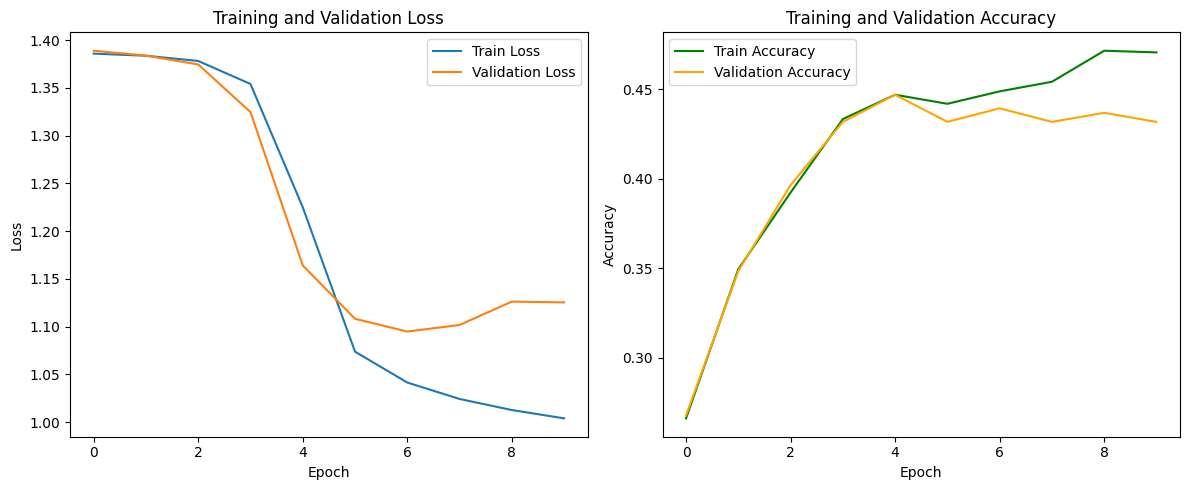

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> bidirectional LSTM </h1>


In [ ]:
class BiLSTMModel(nn.Module):
    """
    Модель двунаправленной LSTM (BiLSTM) для классификации текстов.

    Атрибуты:
        embedding (nn.Embedding): Слой для преобразования индексов слов в эмбеддинги.
        lstm (nn.LSTM): Двунаправленный слой LSTM для обработки последовательностей.
        dropout (nn.Dropout): Слой Dropout для регуляризации.
        fc (nn.Linear): Полносвязный слой для классификации.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        """
        Инициализация модели BiLSTM.

        Параметры:
            vocab_size (int): Размер словаря (количество уникальных токенов).
            embedding_dim (int): Размерность эмбеддингов (векторное представление слов).
            hidden_dim (int): Размерность скрытого состояния LSTM.
            output_dim (int): Количество классов для классификации.
            n_layers (int): Количество слоёв LSTM.
            dropout (float): Вероятность Dropout для регуляризации.
        """
        super(BiLSTMModel, self).__init__()

        # Слой для преобразования индексов слов в эмбеддинги
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Двунаправленный слой LSTM
        # Параметры:
        #   embedding_dim: Размерность входных данных (эмбеддинги).
        #   hidden_dim: Размерность скрытого состояния.
        #   num_layers: Количество слоёв LSTM.
        #   dropout: Вероятность Dropout между слоями LSTM.
        #   batch_first: Если True, входные данные имеют форму (batch_size, seq_len, embedding_dim).
        #   bidirectional: Если True, создаётся двунаправленный LSTM.
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout,
            batch_first=True, bidirectional=True
        )

        # Слой Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

        # Полносвязный слой для классификации
        # Учитываем удвоенную размерность скрытого состояния из-за двунаправленного LSTM
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text, attention_mask=None):
        """
        Прямой проход модели.

        Параметры:
            text (torch.Tensor): Входные данные (последовательность индексов слов).
                                Форма: (batch_size, seq_len)
            attention_mask (torch.Tensor, optional): Маска внимания. По умолчанию None.

        Возвращает:
            torch.Tensor: Выход модели (логиты для классификации).
                          Форма: (batch_size, output_dim)
        """
        # Преобразуем индексы слов в эмбеддинги
        # embedded: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(text)

        # Применяем маску, если она предоставлена
        if attention_mask is not None:
            embedded = embedded * attention_mask.unsqueeze(-1)

        # Пропускаем эмбеддинги через двунаправленный LSTM
        # output: (batch_size, seq_len, hidden_dim * 2) - выходы LSTM на каждом шаге последовательности
        # hidden: (num_layers * 2, batch_size, hidden_dim) - скрытые состояния на последнем шаге
        # cell: (num_layers * 2, batch_size, hidden_dim) - состояния ячеек на последнем шаге
        output, (hidden, cell) = self.lstm(embedded)

        # Конкатенируем последние скрытые состояния из прямого и обратного проходов
        # hidden[-2]: (batch_size, hidden_dim) - скрытое состояние прямого прохода последнего слоя
        # hidden[-1]: (batch_size, hidden_dim) - скрытое состояние обратного прохода последнего слоя
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Применяем Dropout для регуляризации
        hidden = self.dropout(hidden)

        # Пропускаем скрытое состояние через полносвязный слой
        # result: (batch_size, output_dim)
        return self.fc(hidden)


In [ ]:
PRETRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(train_df['writer'].unique())
N_LAYERS = 2
DROPOUT = 0.3
MAX_LEN = 512
BATCH_SIZE = 512
NUM_EPOCH = 100

train_dataset = TextDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_df, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_lstm = BiLSTMModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)
optimizer = optim.AdamW(model_lstm.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model_lstm, device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Параметры для ранней остановки
patience = 3  # Количество эпох, в течение которых потери не должны уменьшаться
min_delta = 0.001  # Минимальное значимое уменьшение потерь
best_val_loss = np.inf  # Лучшее значение потерь на валидации (np.inf положительная бесконечность)
epochs_without_improvement = 0  # Счётчик эпох без улучшения

epoch_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=NUM_EPOCH,
    description='Epochs:',
    bar_style='info',
    orientation='horizontal'
)
display(epoch_progress)

for epoch in range(NUM_EPOCH):
    epoch_progress.value = epoch

    train_loss = trainer.train_model(train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Сохраняем значение потерь на обучении

    train_accuracy = trainer.evaluate_model(train_dataloader, criterion)[1]
    train_accuracies.append(train_accuracy)  # Сохраняем точность на обучении

    val_loss, val_accuracy = trainer.evaluate_model(val_dataloader, criterion)
    val_losses.append(val_loss)  # Сохраняем значение потерь на валидации
    val_accuracies.append(val_accuracy)  # Сохраняем точность на валидации

    print(f"Epoch {epoch + 1}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}!")
        break

print('---' * 30)
test_loss, test_accuracy = trainer.evaluate_model(test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

epoch_progress.bar_style = 'success'


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

IntProgress(value=0, bar_style='info', description='Epochs:')

Training: 100%|██████████| 7/7 [00:26<00:00,  3.77s/it]


Epoch 1, Train Loss: 1.3865, Train Accuracy: 0.2734, Val Loss: 1.3863, Val Accuracy: 0.2576


Training: 100%|██████████| 7/7 [00:18<00:00,  2.57s/it]


Epoch 2, Train Loss: 1.3861, Train Accuracy: 0.2936, Val Loss: 1.3857, Val Accuracy: 0.2702


Training: 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]


Epoch 3, Train Loss: 1.3849, Train Accuracy: 0.3103, Val Loss: 1.3851, Val Accuracy: 0.2828


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 4, Train Loss: 1.3843, Train Accuracy: 0.3223, Val Loss: 1.3845, Val Accuracy: 0.2828


Training: 100%|██████████| 7/7 [00:18<00:00,  2.58s/it]


Epoch 5, Train Loss: 1.3830, Train Accuracy: 0.3393, Val Loss: 1.3840, Val Accuracy: 0.2929


Training: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Epoch 6, Train Loss: 1.3833, Train Accuracy: 0.3646, Val Loss: 1.3834, Val Accuracy: 0.3030


Training: 100%|██████████| 7/7 [00:18<00:00,  2.59s/it]


Epoch 7, Train Loss: 1.3821, Train Accuracy: 0.3832, Val Loss: 1.3827, Val Accuracy: 0.3131


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 8, Train Loss: 1.3807, Train Accuracy: 0.3961, Val Loss: 1.3821, Val Accuracy: 0.3232


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 9, Train Loss: 1.3807, Train Accuracy: 0.3984, Val Loss: 1.3814, Val Accuracy: 0.3258


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 10, Train Loss: 1.3797, Train Accuracy: 0.4040, Val Loss: 1.3807, Val Accuracy: 0.3586


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 11, Train Loss: 1.3785, Train Accuracy: 0.4126, Val Loss: 1.3800, Val Accuracy: 0.3737


Training: 100%|██████████| 7/7 [00:18<00:00,  2.57s/it]


Epoch 12, Train Loss: 1.3781, Train Accuracy: 0.4283, Val Loss: 1.3792, Val Accuracy: 0.3737


Training: 100%|██████████| 7/7 [00:19<00:00,  2.85s/it]


Epoch 13, Train Loss: 1.3769, Train Accuracy: 0.4369, Val Loss: 1.3783, Val Accuracy: 0.3636


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 14, Train Loss: 1.3749, Train Accuracy: 0.4454, Val Loss: 1.3773, Val Accuracy: 0.3712


Training: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


Epoch 15, Train Loss: 1.3744, Train Accuracy: 0.4441, Val Loss: 1.3762, Val Accuracy: 0.3788


Training: 100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


Epoch 16, Train Loss: 1.3729, Train Accuracy: 0.4539, Val Loss: 1.3750, Val Accuracy: 0.3788


Training: 100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


Epoch 17, Train Loss: 1.3715, Train Accuracy: 0.4574, Val Loss: 1.3736, Val Accuracy: 0.3965


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 18, Train Loss: 1.3705, Train Accuracy: 0.4602, Val Loss: 1.3721, Val Accuracy: 0.3939


Training: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


Epoch 19, Train Loss: 1.3679, Train Accuracy: 0.4653, Val Loss: 1.3703, Val Accuracy: 0.4066


Training: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


Epoch 20, Train Loss: 1.3669, Train Accuracy: 0.4703, Val Loss: 1.3682, Val Accuracy: 0.3990


Training: 100%|██████████| 7/7 [00:17<00:00,  2.56s/it]


Epoch 21, Train Loss: 1.3624, Train Accuracy: 0.4757, Val Loss: 1.3658, Val Accuracy: 0.3990


Training: 100%|██████████| 7/7 [00:20<00:00,  2.87s/it]


Epoch 22, Train Loss: 1.3609, Train Accuracy: 0.4817, Val Loss: 1.3628, Val Accuracy: 0.4141


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 23, Train Loss: 1.3574, Train Accuracy: 0.4867, Val Loss: 1.3591, Val Accuracy: 0.4167


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 24, Train Loss: 1.3527, Train Accuracy: 0.4918, Val Loss: 1.3545, Val Accuracy: 0.4217


Training: 100%|██████████| 7/7 [00:20<00:00,  2.87s/it]


Epoch 25, Train Loss: 1.3473, Train Accuracy: 0.4962, Val Loss: 1.3484, Val Accuracy: 0.4318


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 26, Train Loss: 1.3419, Train Accuracy: 0.5019, Val Loss: 1.3404, Val Accuracy: 0.4394


Training: 100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


Epoch 27, Train Loss: 1.3300, Train Accuracy: 0.5076, Val Loss: 1.3295, Val Accuracy: 0.4369


Training: 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]


Epoch 28, Train Loss: 1.3173, Train Accuracy: 0.5120, Val Loss: 1.3139, Val Accuracy: 0.4369


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 29, Train Loss: 1.3053, Train Accuracy: 0.5076, Val Loss: 1.2919, Val Accuracy: 0.4470


Training: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


Epoch 30, Train Loss: 1.2755, Train Accuracy: 0.5066, Val Loss: 1.2620, Val Accuracy: 0.4470


Training: 100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


Epoch 31, Train Loss: 1.2390, Train Accuracy: 0.5110, Val Loss: 1.2246, Val Accuracy: 0.4520


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 32, Train Loss: 1.2013, Train Accuracy: 0.5076, Val Loss: 1.1835, Val Accuracy: 0.4697


Training: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 33, Train Loss: 1.1564, Train Accuracy: 0.5110, Val Loss: 1.1442, Val Accuracy: 0.4773


Training: 100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


Epoch 34, Train Loss: 1.0974, Train Accuracy: 0.5256, Val Loss: 1.1137, Val Accuracy: 0.4798


Training: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 35, Train Loss: 1.0893, Train Accuracy: 0.5347, Val Loss: 1.0905, Val Accuracy: 0.5051


Training: 100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


Epoch 36, Train Loss: 1.0738, Train Accuracy: 0.5347, Val Loss: 1.0734, Val Accuracy: 0.5152


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 37, Train Loss: 1.0372, Train Accuracy: 0.5360, Val Loss: 1.0631, Val Accuracy: 0.5152


Training: 100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


Epoch 38, Train Loss: 1.0385, Train Accuracy: 0.5372, Val Loss: 1.0570, Val Accuracy: 0.5177


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 39, Train Loss: 1.0408, Train Accuracy: 0.5426, Val Loss: 1.0533, Val Accuracy: 0.5202


Training: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


Epoch 40, Train Loss: 1.0328, Train Accuracy: 0.5467, Val Loss: 1.0510, Val Accuracy: 0.5126


Training: 100%|██████████| 7/7 [00:17<00:00,  2.57s/it]


Epoch 41, Train Loss: 1.0356, Train Accuracy: 0.5530, Val Loss: 1.0494, Val Accuracy: 0.4949


Training: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 42, Train Loss: 1.0372, Train Accuracy: 0.5584, Val Loss: 1.0483, Val Accuracy: 0.4924


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 43, Train Loss: 1.0301, Train Accuracy: 0.5631, Val Loss: 1.0471, Val Accuracy: 0.5000


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 44, Train Loss: 1.0101, Train Accuracy: 0.5732, Val Loss: 1.0462, Val Accuracy: 0.5101


Training: 100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


Epoch 45, Train Loss: 1.0246, Train Accuracy: 0.5773, Val Loss: 1.0456, Val Accuracy: 0.5278


Training: 100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


Epoch 46, Train Loss: 1.0176, Train Accuracy: 0.5859, Val Loss: 1.0451, Val Accuracy: 0.5126


Training: 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]


Epoch 47, Train Loss: 1.0168, Train Accuracy: 0.5884, Val Loss: 1.0442, Val Accuracy: 0.5152


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 48, Train Loss: 1.0196, Train Accuracy: 0.5827, Val Loss: 1.0430, Val Accuracy: 0.5101


Training: 100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


Epoch 49, Train Loss: 1.0064, Train Accuracy: 0.5814, Val Loss: 1.0421, Val Accuracy: 0.5278


Training: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 50, Train Loss: 1.0085, Train Accuracy: 0.5874, Val Loss: 1.0418, Val Accuracy: 0.5328


Training: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 51, Train Loss: 1.0134, Train Accuracy: 0.5890, Val Loss: 1.0421, Val Accuracy: 0.5303


Training: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


Epoch 52, Train Loss: 1.0020, Train Accuracy: 0.5941, Val Loss: 1.0414, Val Accuracy: 0.5278


Training: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Epoch 53, Train Loss: 1.0054, Train Accuracy: 0.5906, Val Loss: 1.0404, Val Accuracy: 0.5303


Training: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 54, Train Loss: 1.0002, Train Accuracy: 0.5960, Val Loss: 1.0392, Val Accuracy: 0.5328


Training: 100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


Epoch 55, Train Loss: 0.9845, Train Accuracy: 0.5963, Val Loss: 1.0371, Val Accuracy: 0.5354


Training: 100%|██████████| 7/7 [00:20<00:00,  2.94s/it]


Epoch 56, Train Loss: 0.9959, Train Accuracy: 0.5979, Val Loss: 1.0379, Val Accuracy: 0.5404


Training: 100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


Epoch 57, Train Loss: 0.9881, Train Accuracy: 0.5979, Val Loss: 1.0378, Val Accuracy: 0.5429


Training: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 58, Train Loss: 0.9779, Train Accuracy: 0.5969, Val Loss: 1.0316, Val Accuracy: 0.5455


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 59, Train Loss: 0.9853, Train Accuracy: 0.5960, Val Loss: 1.0304, Val Accuracy: 0.5379


Training: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 60, Train Loss: 0.9700, Train Accuracy: 0.5975, Val Loss: 1.0279, Val Accuracy: 0.5480


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 61, Train Loss: 0.9604, Train Accuracy: 0.6026, Val Loss: 1.0201, Val Accuracy: 0.5530


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 62, Train Loss: 0.9577, Train Accuracy: 0.6001, Val Loss: 1.0167, Val Accuracy: 0.5505


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 63, Train Loss: 0.9513, Train Accuracy: 0.6064, Val Loss: 1.0125, Val Accuracy: 0.5606


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 64, Train Loss: 0.9426, Train Accuracy: 0.6054, Val Loss: 1.0057, Val Accuracy: 0.5556


Training: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 65, Train Loss: 0.9408, Train Accuracy: 0.6042, Val Loss: 0.9956, Val Accuracy: 0.5480


Training: 100%|██████████| 7/7 [00:18<00:00,  2.61s/it]


Epoch 66, Train Loss: 0.9189, Train Accuracy: 0.6064, Val Loss: 0.9869, Val Accuracy: 0.5556


Training: 100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


Epoch 67, Train Loss: 0.8916, Train Accuracy: 0.6064, Val Loss: 0.9758, Val Accuracy: 0.5732


Training: 100%|██████████| 7/7 [00:18<00:00,  2.67s/it]


Epoch 68, Train Loss: 0.9023, Train Accuracy: 0.6057, Val Loss: 0.9648, Val Accuracy: 0.5707


Training: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Epoch 69, Train Loss: 0.8735, Train Accuracy: 0.6136, Val Loss: 0.9506, Val Accuracy: 0.5707


Training: 100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


Epoch 70, Train Loss: 0.8792, Train Accuracy: 0.6177, Val Loss: 0.9371, Val Accuracy: 0.5783


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 71, Train Loss: 0.8566, Train Accuracy: 0.6212, Val Loss: 0.9278, Val Accuracy: 0.5808


Training: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 72, Train Loss: 0.8288, Train Accuracy: 0.6228, Val Loss: 0.9115, Val Accuracy: 0.5732


Training: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 73, Train Loss: 0.8184, Train Accuracy: 0.6291, Val Loss: 0.9030, Val Accuracy: 0.5808


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 74, Train Loss: 0.8271, Train Accuracy: 0.6342, Val Loss: 0.8941, Val Accuracy: 0.5884


Training: 100%|██████████| 7/7 [00:19<00:00,  2.86s/it]


Epoch 75, Train Loss: 0.7975, Train Accuracy: 0.6414, Val Loss: 0.8865, Val Accuracy: 0.6035


Training: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 76, Train Loss: 0.8012, Train Accuracy: 0.6484, Val Loss: 0.8823, Val Accuracy: 0.6136


Training: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


Epoch 77, Train Loss: 0.7852, Train Accuracy: 0.6622, Val Loss: 0.8730, Val Accuracy: 0.6086


Training: 100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


Epoch 78, Train Loss: 0.7831, Train Accuracy: 0.6730, Val Loss: 0.8684, Val Accuracy: 0.6187


Training: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


Epoch 79, Train Loss: 0.7616, Train Accuracy: 0.6758, Val Loss: 0.8681, Val Accuracy: 0.6263


Training: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 80, Train Loss: 0.7730, Train Accuracy: 0.6818, Val Loss: 0.8606, Val Accuracy: 0.6313


Training: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


Epoch 81, Train Loss: 0.7529, Train Accuracy: 0.6853, Val Loss: 0.8513, Val Accuracy: 0.6364


Training: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 82, Train Loss: 0.7300, Train Accuracy: 0.6828, Val Loss: 0.8552, Val Accuracy: 0.6364


Training: 100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


Epoch 83, Train Loss: 0.7412, Train Accuracy: 0.6888, Val Loss: 0.8515, Val Accuracy: 0.6414


Training: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 84, Train Loss: 0.7174, Train Accuracy: 0.6970, Val Loss: 0.8416, Val Accuracy: 0.6465


Training: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 85, Train Loss: 0.7195, Train Accuracy: 0.6992, Val Loss: 0.8384, Val Accuracy: 0.6566


Training: 100%|██████████| 7/7 [00:18<00:00,  2.58s/it]


Epoch 86, Train Loss: 0.7143, Train Accuracy: 0.6967, Val Loss: 0.8489, Val Accuracy: 0.6414


Training: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 87, Train Loss: 0.7295, Train Accuracy: 0.6973, Val Loss: 0.8242, Val Accuracy: 0.6465


Training: 100%|██████████| 7/7 [00:19<00:00,  2.73s/it]


Epoch 88, Train Loss: 0.7177, Train Accuracy: 0.6973, Val Loss: 0.8175, Val Accuracy: 0.6616


Training: 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


Epoch 89, Train Loss: 0.7060, Train Accuracy: 0.7036, Val Loss: 0.8127, Val Accuracy: 0.6465


Training: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 90, Train Loss: 0.7086, Train Accuracy: 0.7105, Val Loss: 0.8138, Val Accuracy: 0.6288


Training: 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


Epoch 91, Train Loss: 0.6865, Train Accuracy: 0.7105, Val Loss: 0.8094, Val Accuracy: 0.6364


Training: 100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


Epoch 92, Train Loss: 0.6775, Train Accuracy: 0.7118, Val Loss: 0.8158, Val Accuracy: 0.6313


Training: 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]


Epoch 93, Train Loss: 0.6796, Train Accuracy: 0.7184, Val Loss: 0.8228, Val Accuracy: 0.6465


Training: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 94, Train Loss: 0.6640, Train Accuracy: 0.7162, Val Loss: 0.8163, Val Accuracy: 0.6616
Early stopping at epoch 93!
------------------------------------------------------------------------------------------
Test Loss: 0.7372, Test Accuracy: 0.6692


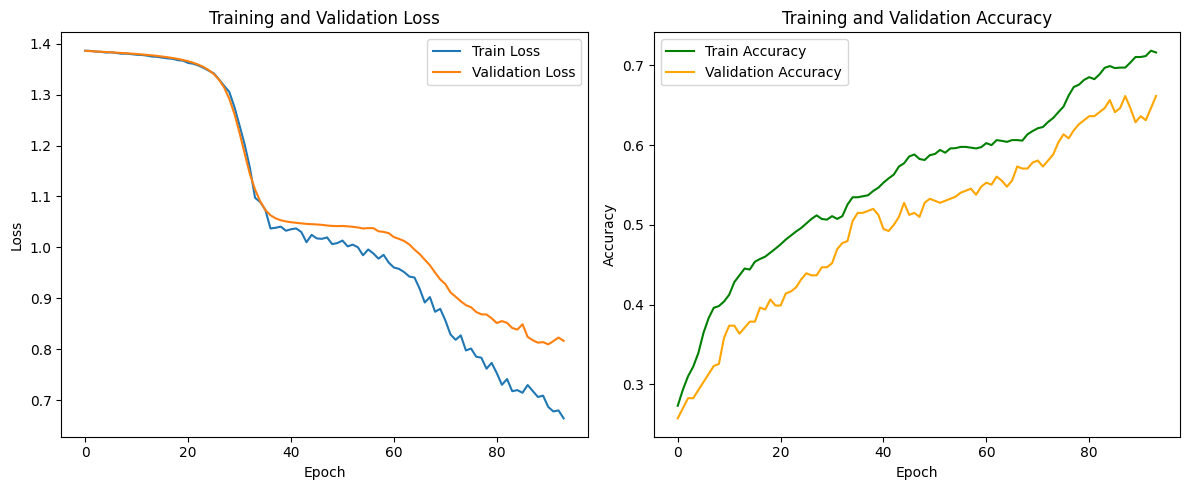

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
